In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import seaborn as sns

In [2]:
# Code for cool SQL query and filling empty values

In [3]:
data = pd.read_csv('Exam_Score_Prediction.csv')
data.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [4]:
# Parametrs that can be changed
seed = 52
metric = 'MAE' #select maximize or minimize in hyperparams search with optuna (cell 12)

In [5]:
from sklearn.model_selection import train_test_split

y = data.exam_score
X = data.drop('exam_score',axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2,random_state= seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state= seed)

In [ ]:
num_cols = X.select_dtypes(include=[np.number])
num_cat_cols = [col for col in num_cols if X[col].nunique() <= 10]
cat_cols = (
    X.select_dtypes(include=['object', 'category']).columns.tolist() +
    num_cat_cols
)

print(cat_cols)

params = {
    'eval_metric' : metric,
    'cat_features': cat_cols,
    'use_best_model': True,
    'early_stopping_rounds': 200,
    'random_seed': seed,
    'ignored_features': None,
    'train_dir': None,
    'verbose': False,
    
    }

['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'age']


In [32]:
cbr_1 = CatBoostRegressor(**params)
cbr_1.fit(X_train,y_train,
        eval_set=(X_valid,y_valid),
        plot = True,
        )
val_metric = cbr_1.evals_result_['validation'][f'{metric}']
print(f"Лучший {metric}: {min(val_metric):.6f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Лучший MAE: 7.841304


In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
dr = DummyRegressor() 
dr.fit(X_train, y_train)
y_dummy_pred = dr.predict(X_test)
print(f'{metric}', mean_absolute_error(y_test,y_dummy_pred))

MAE 15.81123240640625


<Axes: xlabel='None', ylabel='None'>

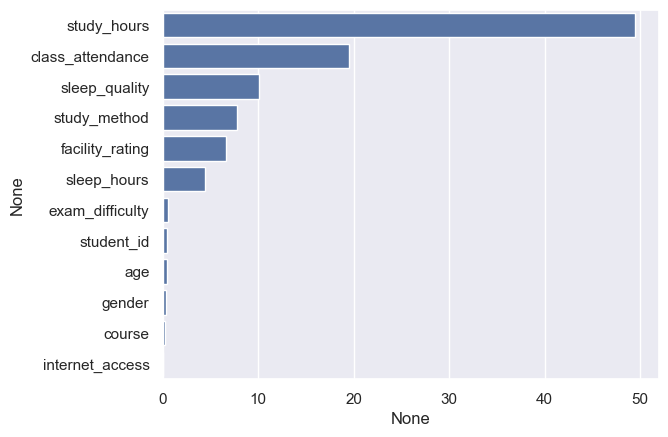

In [33]:
sns.set_theme(style="darkgrid")
importance_df = pd.Series(cbr_1.feature_importances_,index = X_train.columns.to_list())
sns.barplot(x = importance_df.sort_values(ascending=False),y = importance_df.sort_values(ascending=False).index)

In [35]:
params['ignored_features'] = ['student_id','internet_access']
cbr_2 = CatBoostRegressor(**params)
cbr_2.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          plot = True,
          use_best_model=True,
          )
val_metric = cbr_1.evals_result_['validation'][f'{metric}']
print(f"Лучший {metric}: {min(val_metric):.6f}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Лучший MAE: 7.841304


<Axes: xlabel='None', ylabel='None'>

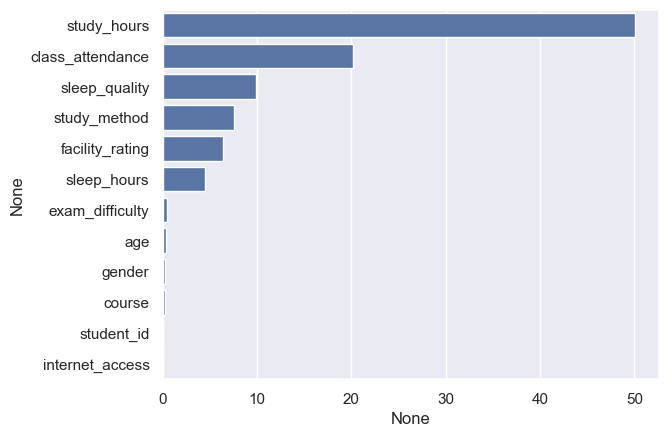

In [36]:
importance_df = pd.Series(cbr_2.feature_importances_, index = X_train.columns.to_list())
sns.barplot(x = importance_df.sort_values(ascending=False),y = importance_df.sort_values(ascending=False).index)

In [37]:
import optuna
from optuna.samplers import TPESampler
from catboost.utils import eval_metric

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'cat_features': cat_cols,
        'train_dir': None,
        'ignored_features': ['student_id','internet_access'],
    }
    model = CatBoostRegressor(**params, random_seed=seed)
    model.fit(X_train,y_train, verbose=0, eval_set=(X_valid,y_valid))
    y_pred = model.predict(X_valid)
    return eval_metric(y_valid, y_pred, metric = metric)

sampler = TPESampler(seed=seed)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=20)

[I 2025-12-13 01:09:06,987] A new study created in memory with name: no-name-25b8a357-c71a-472c-b642-b712d6b81a87
[I 2025-12-13 01:09:24,939] Trial 0 finished with value: 7.844866740289608 and parameters: {'learning_rate': 0.08407993066388128, 'depth': 3, 'l2_leaf_reg': 2.8969357593816456, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 7.844866740289608.
[I 2025-12-13 01:09:43,348] Trial 1 finished with value: 7.852529942128286 and parameters: {'learning_rate': 0.0658118178889173, 'depth': 3, 'l2_leaf_reg': 9.645886520238147, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 7.844866740289608.
[I 2025-12-13 01:10:37,929] Trial 2 finished with value: 7.858611861808341 and parameters: {'learning_rate': 0.06728980103519931, 'depth': 9, 'l2_leaf_reg': 7.884597651551373, 'boosting_type': 'Plain'}. Best is trial 0 with value: 7.844866740289608.
[I 2025-12-13 01:11:39,470] Trial 3 finished with value: 7.844269701788559 and parameters: {'learning_rate': 0.04808815753708286, 'd

In [39]:
final_params = {**params,**study.best_params,
                'iterations' : 3000, # there was no min value with default
                'ignored_features' : ['student_id','internet_access']
    }
final_params

{'eval_metric': 'MAE',
 'cat_features': ['gender',
  'course',
  'internet_access',
  'sleep_quality',
  'study_method',
  'facility_rating',
  'exam_difficulty',
  'age'],
 'use_best_model': True,
 'early_stopping_rounds': 200,
 'random_seed': 52,
 'ignored_features': ['student_id', 'internet_access'],
 'train_dir': None,
 'verbose': False,
 'learning_rate': 0.028769898734659564,
 'depth': 7,
 'l2_leaf_reg': 4.256898504473581,
 'boosting_type': 'Plain',
 'iterations': 3000}

In [ ]:
cbr_final = CatBoostRegressor(**final_params)
# X_train_imp_ftr = X_train.drop(['student_id','internet_access'],axis=1).copy()
# X_valid_imp_ftr = X_valid.drop(['student_id','internet_access'],axis=1).copy()
cbr_final.fit(X_train,y_train, cat_features = cat_cols, eval_set=(X_valid,y_valid), plot = True)

y_pred = cbr_final.predict(X_test)

print(eval_metric(y_test.values, y_pred, metric = metric))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

[7.867291796786404]
